In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel

In [46]:
explore_turn_12 = pd.read_csv("../explore_turn_12.csv")
explore_user = pd.read_csv("../explore_user_common.csv")

In [47]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)   
pd.set_option('display.max_rows', None)      

In [48]:
explore_turn_12.columns

Index(['Unnamed: 0', 'utterance_id', 'turn_id', 'chat_id', 'datetime',
       'user_utterance', 'valence', 'label', 'sublabel', 'bot_action',
       'bot_datetime', 'bot_utterance', 'user_rating',
       'user_rating_explanation', 'valence_new', 'label_new', 'sublabel_new',
       'user_utterance_english', 'bot_utterance_english',
       'Contained technical issue', 'user_rating_english',
       'user_rating_explanation_english', 'user_sentiment', 'bot_sentiment',
       'LSM_LIWC', 'user_features', 'bot_features', 'LSM_EMPATH'],
      dtype='object')

In [49]:
explore_user.columns

Index(['Unnamed: 0', 'Submission id', 'condition', 'Age', 'Sex', 'education',
       'job', 'start_time', 'end_time', 'Time taken',
       'identification_with_goal', 'current_pursuit_of_target',
       'readiness_to_change_start', 'readiness_to_change_end',
       'general_remarks', 'attention_check_passed', 'Therapeutic Alliance',
       'Perception of MI', 'User Engagement - Focused Attention',
       'User Engagement - Perceived Usability', 'User Engagement - Reward',
       'User Engagement - Overall', 'Communication Competence',
       'Perceived Empathy', 'Readiness to Change (Delta)',
       'Stage of Change (Start)', 'chat_id'],
      dtype='object')

#### Participants were divided into three equally sized groups (low, medium, and high) based on their self-reported Therapeutic Alliance scores

In [50]:
lower_q = explore_user['Therapeutic Alliance'].quantile(2/5)
upper_q = explore_user['Therapeutic Alliance'].quantile(3/5)

def assign_group(x):
    if x <= lower_q:
        return 'Low'
    elif x >= upper_q:
        return 'High'
    else:
        return 'Mid' 

#Add a new column, indicate the performance on 'Therapeutic Alliance' as "high", "mid", "low"
explore_user['TA_group'] = explore_user['Therapeutic Alliance'].apply(assign_group)

In [51]:
explore_user.isnull().sum()

Unnamed: 0                                 0
Submission id                              0
condition                                  0
Age                                        0
Sex                                        0
education                                  0
job                                        1
start_time                                 0
end_time                                   0
Time taken                                 0
identification_with_goal                   1
current_pursuit_of_target                  1
readiness_to_change_start                  1
readiness_to_change_end                    1
general_remarks                          110
attention_check_passed                     0
Therapeutic Alliance                       0
Perception of MI                           0
User Engagement - Focused Attention        0
User Engagement - Perceived Usability      0
User Engagement - Reward                   0
User Engagement - Overall                  0
Communicat

#### Merge the `TA_group` columns from explore_user to explore_turn

In [52]:
ta_group_df = explore_user[['chat_id', 'TA_group', 'condition']]
explore_turn_12 = explore_turn_12.merge(ta_group_df, on='chat_id', how='left')

In [53]:
explore_turn_12.isnull().sum()

Unnamed: 0                            0
utterance_id                          0
turn_id                               0
chat_id                               0
datetime                              0
user_utterance                        8
valence                               0
label                               914
sublabel                           1104
bot_action                          978
bot_datetime                         16
bot_utterance                        13
user_rating                         746
user_rating_explanation            1086
valence_new                           0
label_new                           914
sublabel_new                       1104
user_utterance_english                0
bot_utterance_english                 0
Contained technical issue            48
user_rating_english                 746
user_rating_explanation_english    1086
user_sentiment                        0
bot_sentiment                         0
LSM_LIWC                              2


In [54]:
explore_turn_12 = explore_turn_12[explore_turn_12['TA_group'] != "Mid"]

#### After deleting the middle group, we still have 118 chats left

In [55]:
total= explore_turn_12["chat_id"].nunique()
total

118

# Distribution of high group and low group within these two conditions

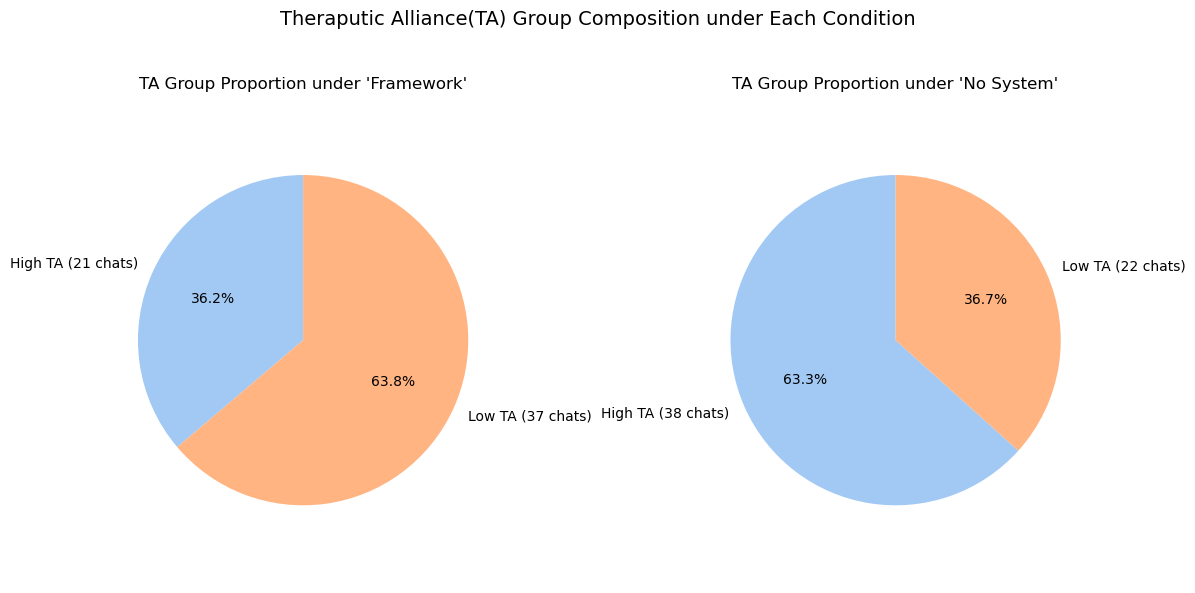

In [56]:
# Create crosstab for chat_id count
crosstab_counts = pd.crosstab(
    explore_turn_12['TA_group'],
    explore_turn_12['condition'],
    values=explore_turn_12['chat_id'],
    aggfunc=lambda x: x.nunique()
)

# Plot pie charts for each condition
conditions = crosstab_counts.columns.tolist()
ta_groups = crosstab_counts.index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, condition in enumerate(conditions):
    # Get values and labels for current condition
    values = crosstab_counts[condition]
    labels = [f"{group} TA ({values[group]} chats)" for group in ta_groups]

    # Plot pie chart
    axes[i].pie(
        values,
        labels=labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=sns.color_palette("pastel")[0:len(values)]
    )
    axes[i].axis('equal')  # Equal aspect ratio ensures a perfect circle
    axes[i].set_title(f"TA Group Proportion under '{condition.replace('_', ' ').title()}'")

# Final layout adjustment
plt.suptitle("Theraputic Alliance(TA) Group Composition under Each Condition", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Visualisation of bot/user utterance length by turn, TA Group and experiment sitting.

## Bot Utterance

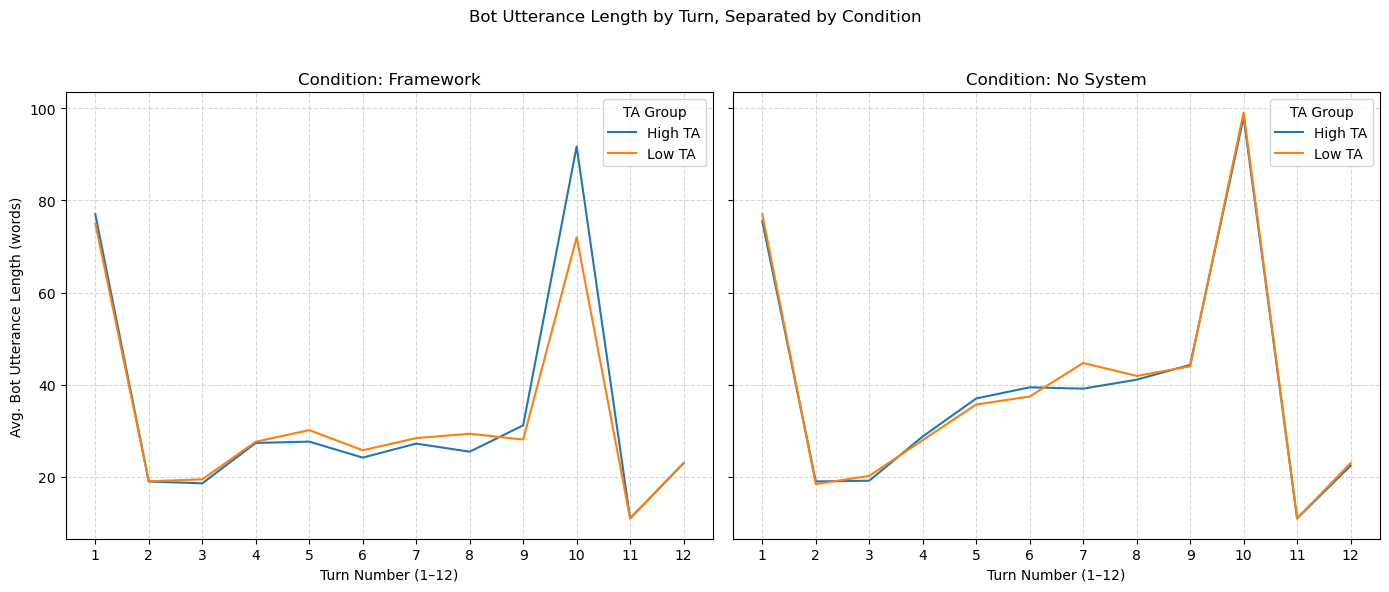

In [57]:
# Calculate bot utterance length
explore_turn_12['bot_utterance_length'] = explore_turn_12['bot_utterance_english'].str.split().str.len()

# Group by TA_group, condition, and turn_id
avg_by_turn = explore_turn_12.groupby(['condition', 'TA_group', 'turn_id'])['bot_utterance_length'].mean().reset_index()

# Create subplot — one for each condition
conditions = ['framework', 'no_system']
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, condition in enumerate(conditions):
    ax = axes[i]
    for ta_group in ['High', 'Low']:
        group_data = avg_by_turn[
            (avg_by_turn['condition'] == condition) &
            (avg_by_turn['TA_group'] == ta_group)
        ]
        label = f"{ta_group} TA"
        ax.plot(group_data['turn_id'], group_data['bot_utterance_length'], label=label)

    # Set titles and labels for each subplot
    ax.set_title(f"Condition: {condition.replace('_', ' ').title()}")
    ax.set_xlabel("Turn Number (1–12)")
    ax.set_xticks(range(1, 13))
    ax.grid(True, linestyle='--', alpha=0.5)
    if i == 0:
        ax.set_ylabel("Avg. Bot Utterance Length (words)")
    ax.legend(title="TA Group")

# Final layout adjustments
plt.suptitle("Bot Utterance Length by Turn, Separated by Condition")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### in 'framework' condition

#### check the normal distribution 

In [58]:
high_group = avg_by_turn[
    (avg_by_turn['TA_group'] == 'High') &
    (avg_by_turn['condition'] == 'framework')
]['bot_utterance_length'].reset_index(drop=True)

low_group = avg_by_turn[
    (avg_by_turn['TA_group'] == 'Low') &
    (avg_by_turn['condition'] == 'framework')
]['bot_utterance_length'].reset_index(drop=True)

# Apply Shapiro-Wilk normality test
stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)

# Print results
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

# Interpret results
print("Interpretation:")
print("High group looks Gaussian" if p_high > 0.1 else "High group does NOT look Gaussian")
print("Low group looks Gaussian" if p_low > 0.1 else "Low group does NOT look Gaussian")

High group: p = 0.0007
Low group: p = 0.0015
Interpretation:
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in bot utterance under 'framework' condition

In [59]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in bot utterance length under 'framework' condition")
else:
    print("Significant difference between High and Low groups in bot utterance length under 'framework' condition")

Wilcoxon test p-value: 0.7695
No significant difference between High and Low groups in bot utterance length under 'framework' condition


### in 'no_system' condition

#### check the normal distribution 

In [60]:
high_group = avg_by_turn[
    (avg_by_turn['TA_group'] == 'High') &
    (avg_by_turn['condition'] == 'no_system')
]['bot_utterance_length'].reset_index(drop=True)

low_group = avg_by_turn[
    (avg_by_turn['TA_group'] == 'Low') &
    (avg_by_turn['condition'] == 'no_system')
]['bot_utterance_length'].reset_index(drop=True)

# Apply Shapiro-Wilk normality test
stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)

# Print results
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

# Interpret results
print("Interpretation:")
print("High group looks Gaussian" if p_high > 0.1 else "High group does NOT look Gaussian")
print("Low group looks Gaussian" if p_low > 0.1 else "Low group does NOT look Gaussian")

High group: p = 0.0442
Low group: p = 0.0562
Interpretation:
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in bot utterance under 'no_system' condition

In [61]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in bot utterance length under 'no_system' condition")
else:
    print("Significant difference between High and Low groups in bot utterance length under 'no_system' condition")

Wilcoxon test p-value: 0.5771
No significant difference between High and Low groups in bot utterance length under 'no_system' condition


## User Utterance

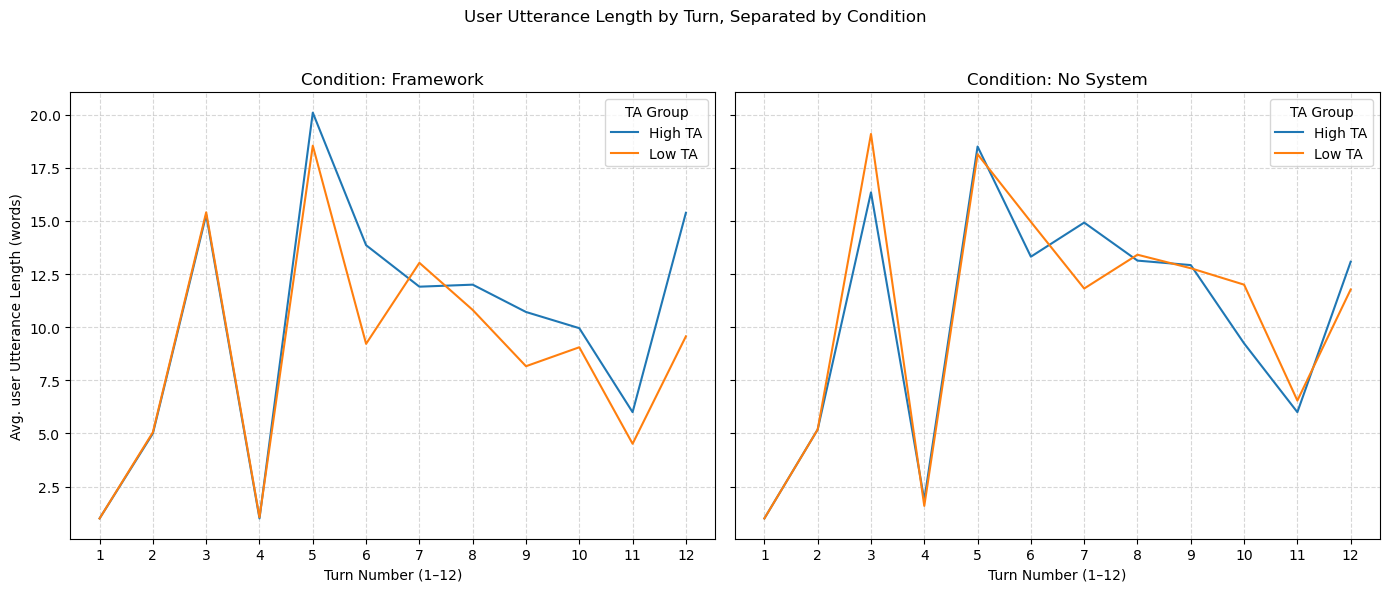

In [62]:
import matplotlib.pyplot as plt

# Calculate user utterance length
explore_turn_12['user_utterance_length'] = explore_turn_12['user_utterance_english'].str.split().str.len()

# Group by TA_group, condition, and turn_id
avg_by_turn = explore_turn_12.groupby(['condition', 'TA_group', 'turn_id'])['user_utterance_length'].mean().reset_index()

# Create subplot — one for each condition
conditions = ['framework', 'no_system']
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, condition in enumerate(conditions):
    ax = axes[i]
    for ta_group in ['High', 'Low']:
        group_data = avg_by_turn[
            (avg_by_turn['condition'] == condition) &
            (avg_by_turn['TA_group'] == ta_group)
        ]
        label = f"{ta_group} TA"
        ax.plot(group_data['turn_id'], group_data['user_utterance_length'], label=label)

    # Set titles and labels for each subplot
    ax.set_title(f"Condition: {condition.replace('_', ' ').title()}")
    ax.set_xlabel("Turn Number (1–12)")
    ax.set_xticks(range(1, 13))
    ax.grid(True, linestyle='--', alpha=0.5)
    if i == 0:
        ax.set_ylabel("Avg. user Utterance Length (words)")
    ax.legend(title="TA Group")

# Final layout adjustments
plt.suptitle("User Utterance Length by Turn, Separated by Condition")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### in 'framework' condition

#### check the normal distribution 

In [63]:
high_group = avg_by_turn[
    (avg_by_turn['TA_group'] == 'High') &
    (avg_by_turn['condition'] == 'framework')
]['user_utterance_length'].reset_index(drop=True)

low_group = avg_by_turn[
    (avg_by_turn['TA_group'] == 'Low') &
    (avg_by_turn['condition'] == 'framework')
]['user_utterance_length'].reset_index(drop=True)

# Apply Shapiro-Wilk normality test
stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)

# Print results
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

# Interpret results
print("Interpretation:")
print("High group looks Gaussian" if p_high > 0.1 else "High group does NOT look Gaussian")
print("Low group looks Gaussian" if p_low > 0.1 else "Low group does NOT look Gaussian")

High group: p = 0.6542
Low group: p = 0.8366
Interpretation:
High group looks Gaussian
Low group looks Gaussian


#### check significant difference ( Paired Samples t-test / paired data condition)
#### result: Significant difference between High and Low groups in user utterance under 'framework' condition

In [64]:
t_stat, p_val = ttest_rel(high_group, low_group)

print(f"Paired Samples t-test p-value: {p_val:.4f}")
if p_val > 0.1:
    print("No significant difference between High and Low groups in user utterance length under 'framework' condition")
else:
    print("Significant difference between High and Low groups in user utterance length under 'framework' condition")

Paired Samples t-test p-value: 0.0380
Significant difference between High and Low groups in user utterance length under 'framework' condition


### in 'no_system' condition

#### check the normal distribution 

In [65]:
high_group = avg_by_turn[
    (avg_by_turn['TA_group'] == 'High') &
    (avg_by_turn['condition'] == 'no_system')
]['user_utterance_length'].reset_index(drop=True)

low_group = avg_by_turn[
    (avg_by_turn['TA_group'] == 'Low') &
    (avg_by_turn['condition'] == 'no_system')
]['user_utterance_length'].reset_index(drop=True)

# Apply Shapiro-Wilk normality test
stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)

# Print results
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

# Interpret results
print("Interpretation:")
print("High group looks Gaussian" if p_high > 0.1 else "High group does NOT look Gaussian")
print("Low group looks Gaussian" if p_low > 0.1 else "Low group does NOT look Gaussian")

High group: p = 0.2931
Low group: p = 0.3611
Interpretation:
High group looks Gaussian
Low group looks Gaussian


#### check significant difference ( Paired Samples t-test / paired data condition)
#### result: No significant difference between High and Low groups in user utterance under 'no_system' condition

In [66]:
t_stat, p_val = ttest_rel(high_group, low_group)

print(f"Paired Samples t-test p-value: {p_val:.4f}")
if p_val > 0.1:
    print("No significant difference between High and Low groups in user utterance length under 'no_system' condition")
else:
    print("Significant difference between High and Low groups in user utterance length under 'no_system' condition")

Paired Samples t-test p-value: 0.6327
No significant difference between High and Low groups in user utterance length under 'no_system' condition


# Visualisation of bot/user sentiment categories

## Proportion of Bot Sentiment Categories by TA Group and Condition

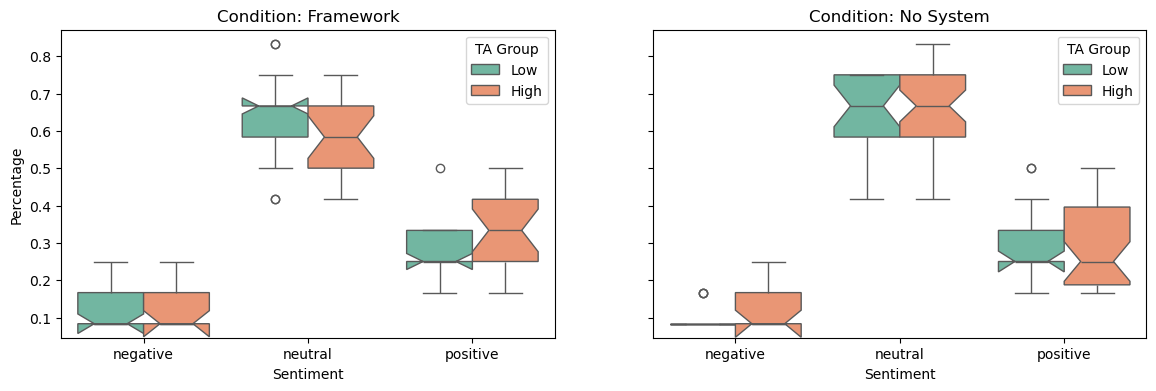

In [67]:
# Sentiment classification function
def classify_sentiment(score):
    if pd.isna(score):
        return None
    elif score < 1.5:
        return 'negative'
    elif score < 2.5:
        return 'neutral'
    else:
        return 'positive'

# Apply sentiment classification
explore_turn_12['bot_sentiment_label'] = explore_turn_12['bot_sentiment'].apply(classify_sentiment)

# Count number of bot utterances per sentiment category per dialogue
counts = explore_turn_12.groupby(['chat_id', 'TA_group', 'condition', 'bot_sentiment_label']).size().reset_index(name='count')

# Calculate percentage within each chat_id
counts['total'] = counts.groupby('chat_id')['count'].transform('sum')
counts['percentage'] = counts['count'] / counts['total']

# Plot two subplots for each condition
conditions = ['framework', 'no_system']
sentiment_order = ['negative', 'neutral', 'positive']

# Set the category order for consistent plotting
counts['bot_sentiment_label'] = pd.Categorical(
    counts['bot_sentiment_label'],
    categories=sentiment_order,
    ordered=True
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for i, condition in enumerate(conditions):
    ax = axes[i]
    subset = counts[counts['condition'] == condition]
    sns.boxplot(
        data=subset,
        x='bot_sentiment_label',
        y='percentage',
        hue='TA_group',
        order=sentiment_order,      # <== fixed order for x-axis
        notch=True,
        palette='Set2',
        ax=ax
    )
    ax.set_title(f"Condition: {condition.replace('_', ' ').title()}")
    ax.set_xlabel("Sentiment")
    if i == 0:
        ax.set_ylabel("Percentage")
    else:
        ax.set_ylabel("")
    ax.legend(title="TA Group")

## Proportion of User Sentiment Categories by TA Group and Condition

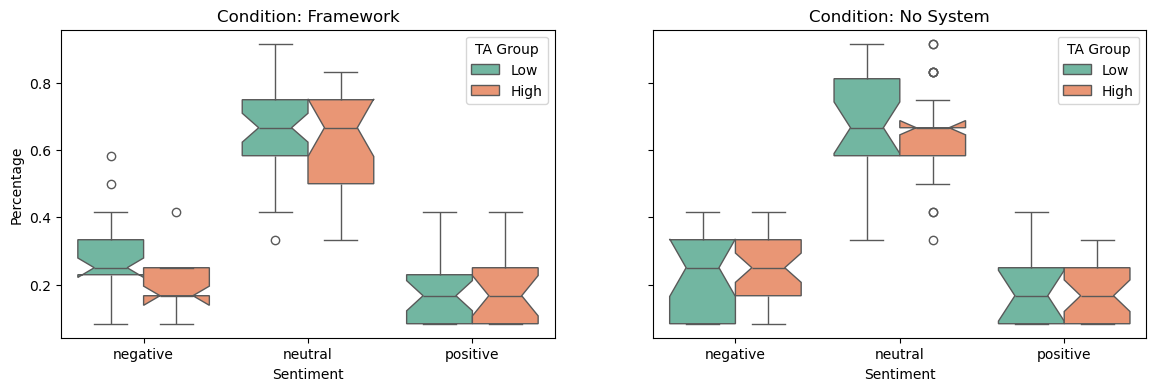

In [68]:
# Sentiment classification function
def classify_sentiment(score):
    if pd.isna(score):
        return None
    elif score < 1.5:
        return 'negative'
    elif score < 2.5:
        return 'neutral'
    else:
        return 'positive'

# Apply sentiment classification
explore_turn_12['user_sentiment_label'] = explore_turn_12['user_sentiment'].apply(classify_sentiment)

# SCount number of user utterances per sentiment category per dialogue
counts = explore_turn_12.groupby(['chat_id', 'TA_group', 'condition', 'user_sentiment_label']).size().reset_index(name='count')

# Calculate percentage within each chat_id
counts['total'] = counts.groupby('chat_id')['count'].transform('sum')
counts['percentage'] = counts['count'] / counts['total']

# Plot two subplots for each condition
conditions = ['framework', 'no_system']
sentiment_order = ['negative', 'neutral', 'positive']

# Set the category order for consistent plotting
counts['user_sentiment_label'] = pd.Categorical(
    counts['user_sentiment_label'],
    categories=sentiment_order,
    ordered=True
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for i, condition in enumerate(conditions):
    ax = axes[i]
    subset = counts[counts['condition'] == condition]
    sns.boxplot(
        data=subset,
        x='user_sentiment_label',
        y='percentage',
        hue='TA_group',
        order=sentiment_order,      # <== fixed order for x-axis
        notch=True,
        palette='Set2',
        ax=ax
    )
    ax.set_title(f"Condition: {condition.replace('_', ' ').title()}")
    ax.set_xlabel("Sentiment")
    if i == 0:
        ax.set_ylabel("Percentage")
    else:
        ax.set_ylabel("")
    ax.legend(title="TA Group")

# Visualisation of bot/user positive sentiment categories by 12 turns

## Bot positive sensitive

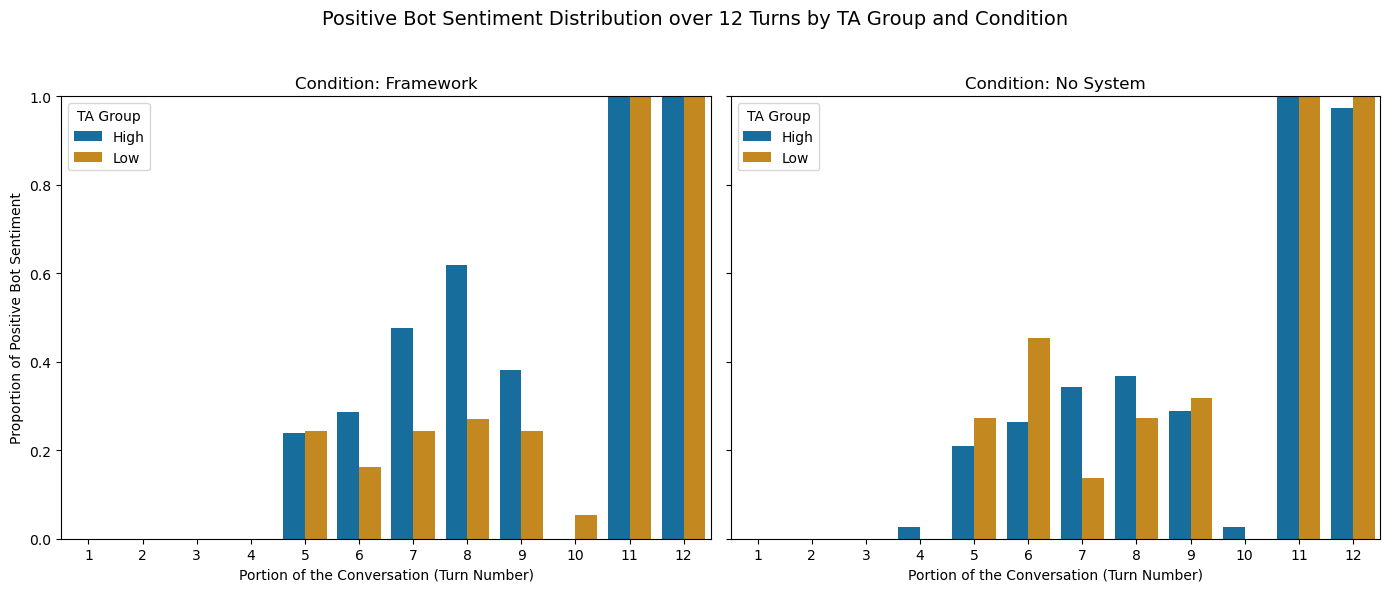

In [69]:
# Mark positive sentiment for bot utterance
explore_turn_12['bot_is_positive'] = explore_turn_12['bot_sentiment_label'] == 'positive'

# Group by turn_id, TA_group, and condition; calculate % positive
bot_positive_by_turn_group = (
    explore_turn_12.groupby(['turn_id', 'TA_group', 'condition'])['bot_is_positive']
    .mean()
    .reset_index(name='positive_ratio')
)

# Set up two subplots for each condition
conditions = ['framework', 'no_system']
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, condition in enumerate(conditions):
    ax = axes[i]
    subset = bot_positive_by_turn_group[bot_positive_by_turn_group['condition'] == condition]
    
    sns.barplot(
        data=subset,
        x='turn_id',
        y='positive_ratio',
        hue='TA_group',
        palette='colorblind',
        errorbar='sd',
        ax=ax
    )
    
    ax.set_title(f"Condition: {condition.replace('_', ' ').title()}")
    ax.set_xlabel("Portion of the Conversation (Turn Number)")
    if i == 0:
        ax.set_ylabel("Proportion of Positive Bot Sentiment")
    else:
        ax.set_ylabel("")
    
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels([str(i + 1) for i in range(12)])
    ax.set_ylim(0, 1)
    ax.legend(title="TA Group")

# Final layout
plt.suptitle("Positive Bot Sentiment Distribution over 12 Turns by TA Group and Condition", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### in 'framework' condition

#### check the normal distribution 

In [70]:
high_group = bot_positive_by_turn_group[
    (bot_positive_by_turn_group['TA_group'] == 'High') &
    (bot_positive_by_turn_group['condition'] == 'framework')
]['positive_ratio'].reset_index(drop=True)

low_group = bot_positive_by_turn_group[
    (bot_positive_by_turn_group['TA_group'] == 'Low') &
    (bot_positive_by_turn_group['condition'] == 'framework')
]['positive_ratio'].reset_index(drop=True)

stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

if p_high > 0.1:
    print("High group looks Gaussian")
else:
    print("High group does NOT look Gaussian")

if p_low > 0.1:
    print("Low group looks Gaussian")
else:
    print("Low group does NOT look Gaussian")

High group: p = 0.0206
Low group: p = 0.0010
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in bot positive utterance under 'framework' condition

In [71]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in bot positive utterance under 'framework' condition")
else:
    print("Significant difference between High and Low groups in bot positive utterance under 'framework' condition")

Wilcoxon test p-value: 0.1562
No significant difference between High and Low groups in bot positive utterance under 'framework' condition


### in 'no_system' condition

#### check the normal distribution 

In [72]:
high_group = bot_positive_by_turn_group[
    (bot_positive_by_turn_group['TA_group'] == 'High') &
    (bot_positive_by_turn_group['condition'] == 'no_system')
]['positive_ratio'].reset_index(drop=True)

low_group = bot_positive_by_turn_group[
    (bot_positive_by_turn_group['TA_group'] == 'Low') &
    (bot_positive_by_turn_group['condition'] == 'no_system')
]['positive_ratio'].reset_index(drop=True)

stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

if p_high > 0.1:
    print("High group looks Gaussian")
else:
    print("High group does NOT look Gaussian")

if p_low > 0.1:
    print("Low group looks Gaussian")
else:
    print("Low group does NOT look Gaussian")

High group: p = 0.0049
Low group: p = 0.0042
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in bot positive utterance under 'no_system' condition

In [73]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in bot positive utterance under 'no_system' condition")
else:
    print("Significant difference between High and Low groups in bot positive utterance under 'no_system' condition")

Wilcoxon test p-value: 0.9219
No significant difference between High and Low groups in bot positive utterance under 'no_system' condition


## User positive sensitve

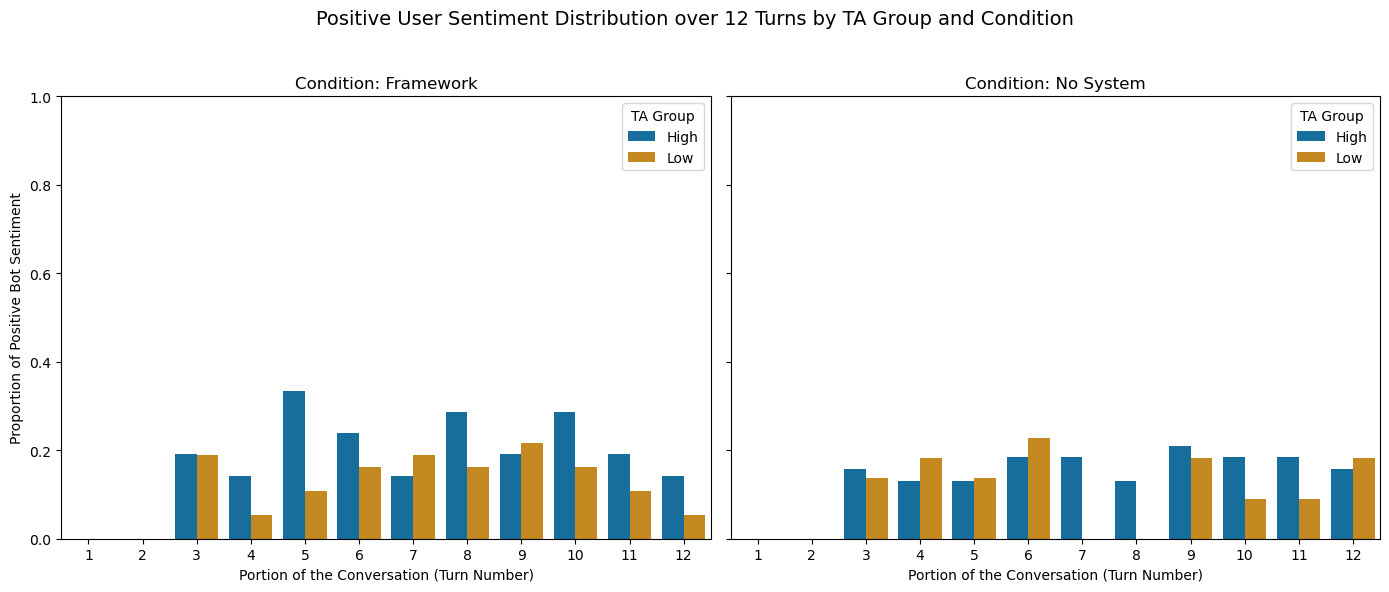

In [74]:
# Mark positive sentiment for user utterance
explore_turn_12['user_is_positive'] = explore_turn_12['user_sentiment_label'] == 'positive'

# Group by turn_id, TA_group, and condition; calculate % positive
user_positive_by_turn_group = (
    explore_turn_12.groupby(['turn_id', 'TA_group', 'condition'])['user_is_positive']
    .mean()
    .reset_index(name='positive_ratio')
)

# Set up two subplots for each condition
conditions = ['framework', 'no_system']
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, condition in enumerate(conditions):
    ax = axes[i]
    subset = user_positive_by_turn_group[user_positive_by_turn_group['condition'] == condition]
    
    sns.barplot(
        data=subset,
        x='turn_id',
        y='positive_ratio',
        hue='TA_group',
        palette='colorblind',
        errorbar='sd',
        ax=ax
    )
    
    ax.set_title(f"Condition: {condition.replace('_', ' ').title()}")
    ax.set_xlabel("Portion of the Conversation (Turn Number)")
    if i == 0:
        ax.set_ylabel("Proportion of Positive Bot Sentiment")
    else:
        ax.set_ylabel("")
    
    ax.set_xticks(range(0, 12))
    ax.set_xticklabels([str(i + 1) for i in range(12)])
    ax.set_ylim(0, 1)
    ax.legend(title="TA Group")

# Final layout
plt.suptitle("Positive User Sentiment Distribution over 12 Turns by TA Group and Condition", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

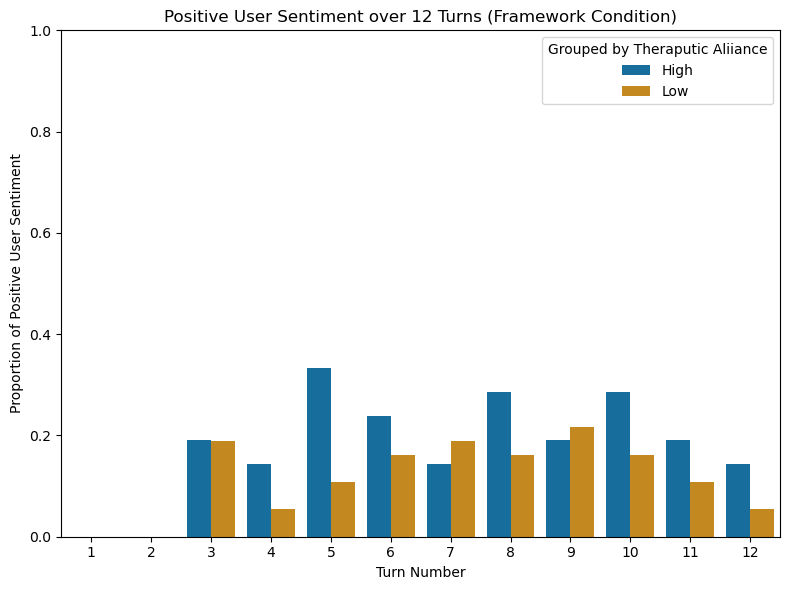

In [90]:
# Mark positive sentiment for user utterance
explore_turn_12['user_is_positive'] = explore_turn_12['user_sentiment_label'] == 'positive'

# Group by turn_id, TA_group, and condition; calculate % positive
user_positive_by_turn_group = (
    explore_turn_12.groupby(['turn_id', 'TA_group', 'condition'])['user_is_positive']
    .mean()
    .reset_index(name='positive_ratio')
)

# Filter only 'framework' condition
framework_data = user_positive_by_turn_group[user_positive_by_turn_group['condition'] == 'framework']

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=framework_data,
    x='turn_id',
    y='positive_ratio',
    hue='TA_group',
    palette='colorblind',
    errorbar='sd',
    ax=ax
)

# Set titles and labels
ax.set_title("Positive User Sentiment over 12 Turns (Framework Condition)")
ax.set_xlabel("Turn Number")
ax.set_ylabel("Proportion of Positive User Sentiment")
ax.set_xticks(range(0, 12))
ax.set_xticklabels([str(i + 1) for i in range(12)])
ax.set_ylim(0, 1)
ax.legend(title="Grouped by Theraputic Aliiance")

# Final layout
plt.tight_layout()
plt.show()

### in 'framework' condition

#### check the normal distribution 

In [75]:
high_group = user_positive_by_turn_group[
    (user_positive_by_turn_group['TA_group'] == 'High') &
    (user_positive_by_turn_group['condition'] == 'framework')
]['positive_ratio'].reset_index(drop=True)

low_group = user_positive_by_turn_group[
    (user_positive_by_turn_group['TA_group'] == 'Low') &
    (user_positive_by_turn_group['condition'] == 'framework')
]['positive_ratio'].reset_index(drop=True)

stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

if p_high > 0.1:
    print("High group looks Gaussian")
else:
    print("High group does NOT look Gaussian")

if p_low > 0.1:
    print("Low group looks Gaussian")
else:
    print("Low group does NOT look Gaussian")

High group: p = 0.3040
Low group: p = 0.1929
High group looks Gaussian
Low group looks Gaussian


#### check significant difference ( Paired Samples t-test / paired data condition)
#### result: Significant difference between High and Low groups in user positive utterance under 'framework' condition

In [76]:
t_stat, p_val = ttest_rel(high_group, low_group)

print(f"Paired Samples t-test p-value: {p_val:.4f}")
if p_val > 0.1:
    print("No significant difference between High and Low groups in user positive utterance under 'framework' condition")
else:
    print("Significant difference between High and Low groups in user positive utterance under 'framework' condition")

Paired Samples t-test p-value: 0.0197
Significant difference between High and Low groups in user positive utterance under 'framework' condition


### in 'no_system' condition

#### check the normal distribution 

In [77]:
high_group = user_positive_by_turn_group[
    (user_positive_by_turn_group['TA_group'] == 'High') &
    (user_positive_by_turn_group['condition'] == 'no_system')
]['positive_ratio'].reset_index(drop=True)

low_group = user_positive_by_turn_group[
    (user_positive_by_turn_group['TA_group'] == 'Low') &
    (user_positive_by_turn_group['condition'] == 'no_system')
]['positive_ratio'].reset_index(drop=True)

stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

if p_high > 0.1:
    print("High group looks Gaussian")
else:
    print("High group does NOT look Gaussian")

if p_low > 0.1:
    print("Low group looks Gaussian")
else:
    print("Low group does NOT look Gaussian")

High group: p = 0.0047
Low group: p = 0.0626
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in user positive utterance under 'no_system' condition

In [78]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in user positive utterance under 'no_system' condition")
else:
    print("Significant difference between High and Low groups in user positive utterance under 'no_system' condition")

Wilcoxon test p-value: 0.2246
No significant difference between High and Low groups in user positive utterance under 'no_system' condition


# Summary

### COMPARE utterance length
#### No significant difference between High and Low groups in bot utterance length under 'framework' condition
#### No significant difference between High and Low groups in bot utterance length under 'no_system' condition

#### Significant difference between High and Low groups in user utterance length under 'framework' condition
#### No significant difference between High and Low groups in user utterance length under 'no_system' condition
---
### COMPARE positive utterance ratio
#### No significant difference between High and Low groups in bot positive utterance under 'framework' condition
#### No significant difference between High and Low groups in bot positive utterance under 'no_system' condition

#### Significant difference between High and Low groups in user positive utterance under 'framework' condition
#### No significant difference between High and Low groups in user positive utterance under 'no_system' condition

# visualisation on LSM_EMPATH by turn and TA Group

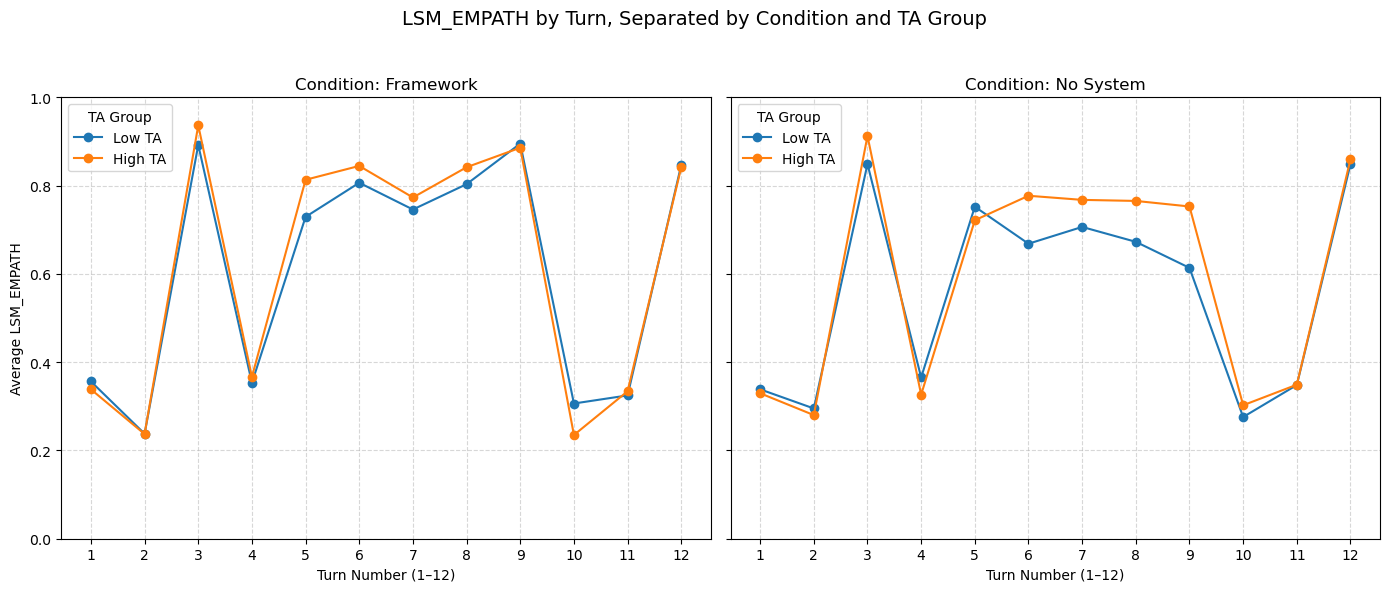

In [79]:
# Group by condition, TA_group, and turn_id to get average LSM_EMPATH
avg_LSM_score_by_turn = (
    explore_turn_12.groupby(['condition', 'TA_group', 'turn_id'])['LSM_EMPATH']
    .mean()
    .reset_index()
)

# Define conditions and create subplots
conditions = ['framework', 'no_system']
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, condition in enumerate(conditions):
    ax = axes[i]
    for group in ['Low', 'High']:
        group_data = avg_LSM_score_by_turn[
            (avg_LSM_score_by_turn['condition'] == condition) &
            (avg_LSM_score_by_turn['TA_group'] == group)
        ]
        ax.plot(
            group_data['turn_id'],
            group_data['LSM_EMPATH'],
            label=f"{group} TA",
            marker='o'
        )
    
    ax.set_title(f"Condition: {condition.replace('_', ' ').title()}")
    ax.set_xlabel("Turn Number (1–12)")
    ax.set_xticks(range(1, 13))
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.5)
    if i == 0:
        ax.set_ylabel("Average LSM_EMPATH")
    else:
        ax.set_ylabel("")
    ax.legend(title="TA Group")

# Final layout
plt.suptitle("LSM_EMPATH by Turn, Separated by Condition and TA Group", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### in 'framework' condition

#### check the normal distribution 

In [80]:
high_group = avg_LSM_score_by_turn[
    (avg_LSM_score_by_turn['TA_group'] == 'High') &
    (avg_LSM_score_by_turn['condition'] == 'framework')
]['LSM_EMPATH'].reset_index(drop=True)

low_group = avg_LSM_score_by_turn[
    (avg_LSM_score_by_turn['TA_group'] == 'Low') &
    (avg_LSM_score_by_turn['condition'] == 'framework')
]['LSM_EMPATH'].reset_index(drop=True)

stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

if p_high > 0.1:
    print("High group looks Gaussian")
else:
    print("High group does NOT look Gaussian")

if p_low > 0.1:
    print("Low group looks Gaussian")
else:
    print("Low group does NOT look Gaussian")

High group: p = 0.0077
Low group: p = 0.0138
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in LSM_EMPATH under 'framework' condition

In [81]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in LSM_EMPATH under 'framework' condition")
else:
    print("Significant difference between High and Low groups in LSM_EMPATH under 'framework' condition")

Wilcoxon test p-value: 0.2334
No significant difference between High and Low groups in LSM_EMPATH under 'framework' condition


### in 'no_system' condition

#### check the normal distribution 

In [82]:
high_group = avg_LSM_score_by_turn[
    (avg_LSM_score_by_turn['TA_group'] == 'High') &
    (avg_LSM_score_by_turn['condition'] == 'no_system')
]['LSM_EMPATH'].reset_index(drop=True)

low_group = avg_LSM_score_by_turn[
    (avg_LSM_score_by_turn['TA_group'] == 'Low') &
    (avg_LSM_score_by_turn['condition'] == 'no_system')
]['LSM_EMPATH'].reset_index(drop=True)

stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

if p_high > 0.1:
    print("High group looks Gaussian")
else:
    print("High group does NOT look Gaussian")

if p_low > 0.1:
    print("Low group looks Gaussian")
else:
    print("Low group does NOT look Gaussian")

High group: p = 0.0107
Low group: p = 0.0627
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in LSM_EMPATH under 'no_system' condition

In [83]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in LSM_EMPATH under 'no_system' condition")
else:
    print("Significant difference between High and Low groups in LSM_EMPATH under 'no_system' condition")

Wilcoxon test p-value: 0.1294
No significant difference between High and Low groups in LSM_EMPATH under 'no_system' condition


# visualisation on LSM_LIWC by turn and TA Group

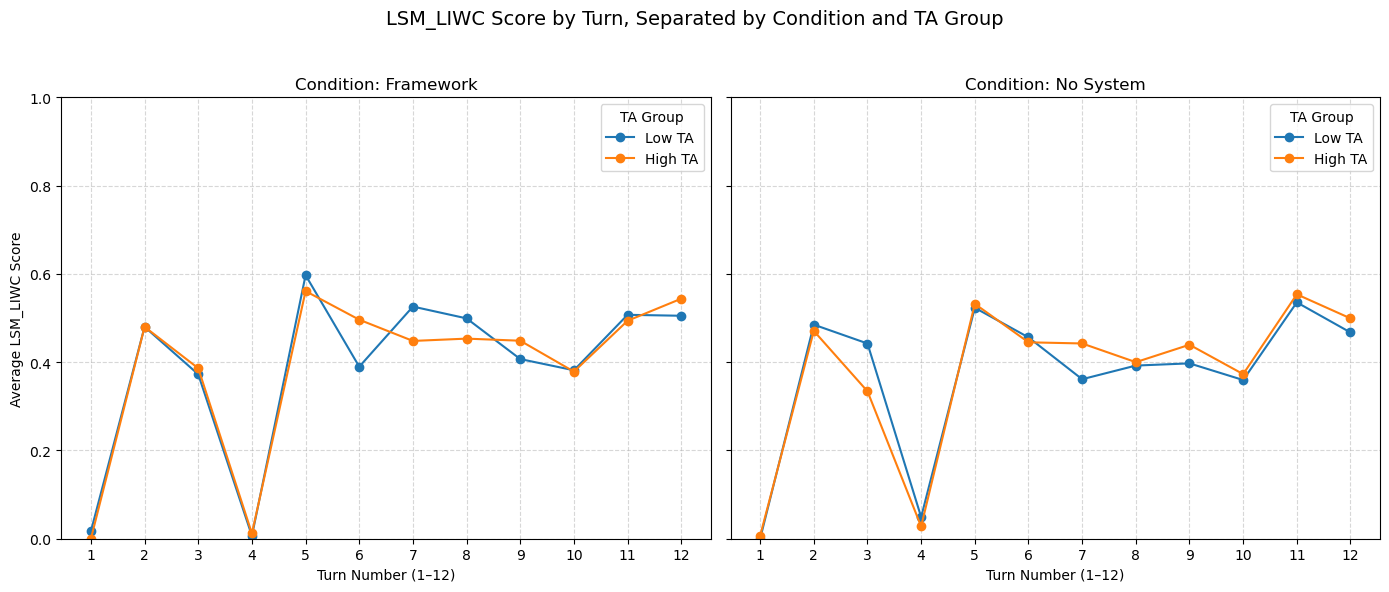

In [84]:
# Group by condition, TA_group, and turn_id to compute average LSM_LIWC
avg_LSM_LIWC_score_by_turn = (
    explore_turn_12.groupby(['condition', 'TA_group', 'turn_id'])['LSM_LIWC']
    .mean()
    .reset_index()
)

# Create two subplots for the two conditions
conditions = ['framework', 'no_system']
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, condition in enumerate(conditions):
    ax = axes[i]
    for group in ['Low', 'High']:
        group_data = avg_LSM_LIWC_score_by_turn[
            (avg_LSM_LIWC_score_by_turn['condition'] == condition) &
            (avg_LSM_LIWC_score_by_turn['TA_group'] == group)
        ]
        ax.plot(
            group_data['turn_id'],
            group_data['LSM_LIWC'],
            label=f"{group} TA",
            marker='o'
        )

    ax.set_title(f"Condition: {condition.replace('_', ' ').title()}")
    ax.set_xlabel("Turn Number (1–12)")
    ax.set_xticks(range(1, 13))
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.5)
    if i == 0:
        ax.set_ylabel("Average LSM_LIWC Score")
    else:
        ax.set_ylabel("")
    ax.legend(title="TA Group")

# Final layout
plt.suptitle("LSM_LIWC Score by Turn, Separated by Condition and TA Group", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### in 'framework' condition

#### check the normal distribution 

In [85]:
high_group = avg_LSM_LIWC_score_by_turn[
    (avg_LSM_LIWC_score_by_turn['TA_group'] == 'High') &
    (avg_LSM_LIWC_score_by_turn['condition'] == 'framework')
]['LSM_LIWC'].reset_index(drop=True)

low_group = avg_LSM_LIWC_score_by_turn[
    (avg_LSM_LIWC_score_by_turn['TA_group'] == 'Low') &
    (avg_LSM_LIWC_score_by_turn['condition'] == 'framework')
]['LSM_LIWC'].reset_index(drop=True)

stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

if p_high > 0.1:
    print("High group looks Gaussian")
else:
    print("High group does NOT look Gaussian")

if p_low > 0.1:
    print("Low group looks Gaussian")
else:
    print("Low group does NOT look Gaussian")

High group: p = 0.0015
Low group: p = 0.0060
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in LSM_LIWC under 'framework' condition

In [86]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in LSM_LIWC under 'framework' condition")
else:
    print("Significant difference between High and Low groups in LSM_LIWC under 'framework' condition")

Wilcoxon test p-value: 0.9697
No significant difference between High and Low groups in LSM_LIWC under 'framework' condition


### in 'no_system' condition

#### check the normal distribution 

In [87]:
high_group = avg_LSM_LIWC_score_by_turn[
    (avg_LSM_LIWC_score_by_turn['TA_group'] == 'High') &
    (avg_LSM_LIWC_score_by_turn['condition'] == 'no_system')
]['LSM_LIWC'].reset_index(drop=True)

low_group = avg_LSM_LIWC_score_by_turn[
    (avg_LSM_LIWC_score_by_turn['TA_group'] == 'Low') &
    (avg_LSM_LIWC_score_by_turn['condition'] == 'no_system')
]['LSM_LIWC'].reset_index(drop=True)

stat_high, p_high = shapiro(high_group)
stat_low, p_low = shapiro(low_group)
print(f"High group: p = {p_high:.4f}")
print(f"Low group: p = {p_low:.4f}")

if p_high > 0.1:
    print("High group looks Gaussian")
else:
    print("High group does NOT look Gaussian")

if p_low > 0.1:
    print("Low group looks Gaussian")
else:
    print("Low group does NOT look Gaussian")

High group: p = 0.0060
Low group: p = 0.0052
High group does NOT look Gaussian
Low group does NOT look Gaussian


#### check significant difference ( Wilcoxon Signed-Rank Test / paired data condition)
#### result: No significant difference between High and Low groups in LSM_LIWC under 'no_system' condition

In [88]:
stat, p = wilcoxon(high_group, low_group)

print(f"Wilcoxon test p-value: {p:.4f}")
if p > 0.1:
    print("No significant difference between High and Low groups in LSM_LIWC under 'no_system' condition")
else:
    print("Significant difference between High and Low groups in LSM_LIWC under 'no_system' condition")

Wilcoxon test p-value: 0.5186
No significant difference between High and Low groups in LSM_LIWC under 'no_system' condition


# Summary

### COMPARE LSM_EMPATH
#### No significant difference between High and Low groups in LSM_EMPATH under 'framework' condition
#### No significant difference between High and Low groups in LSM_EMPATH under 'no_system' condition
----
### COMPARE LSM_LIWC
#### No significant difference between High and Low groups in LSM_LIWC under 'framework' condition
#### No significant difference between High and Low groups in LSM_LIWC under 'no_system' condition